<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузим-данные-и-изучим-их" data-toc-modified-id="Загрузим-данные-и-изучим-их-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузим данные и изучим их</a></span></li><li><span><a href="#Проверка-баланса-классов" data-toc-modified-id="Проверка-баланса-классов-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Проверка баланса классов</a></span></li><li><span><a href="#Лематизация-и-очистка-текстов" data-toc-modified-id="Лематизация-и-очистка-текстов-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Лематизация и очистка текстов</a></span></li><li><span><a href="#Разобьём-данные-на-выборки" data-toc-modified-id="Разобьём-данные-на-выборки-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Разобьём данные на выборки</a></span></li><li><span><a href="#Мешок-слов" data-toc-modified-id="Мешок-слов-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Мешок слов</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Определение негативных комментариев пользователей

Требуется обучить модель классифицировать комментарии на позитивные и негативные.
<br>Заказчик - это интернет-магазин, который запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. 
<br>Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
<br>В вашем распоряжении набор данных с разметкой о токсичности правок.
<br>Требование к модели - значением метрики качества *F1* не меньше 0.75.

## Подготовка

Чтобы изучить данные таблиц, сделать необходимые рассчёты и провести исследование сразу импортируем библиотеки, который нам потребуются в данном проекте:

In [1]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm import notebook

import nltk
import numpy as np
import pandas as pd
import re
import spacy
import torch
import transformers

### Загрузим данные и изучим их

Напишем функцию, которая будет отображать основные показатели датасета и строить корреляционную матрицу

In [2]:
def df_info(df):
    """Изучение датасета"""
    print('\nПервые 10 строчек датафрейма')
    display(df.head(10))
    print('\nИнформация о датафрейме\n')
    display(df.info())
    print('\nРасчёт значений в каждом столбце')
    display(df.describe())
    print('\nКоличество дубликатов =', df.duplicated().sum())
    print('\nЧисло пропусков в каждом столбце')
    display(df.isna().sum())

Прочитаем файл и сохраним его

In [3]:
df = pd.read_csv('C:\\Users\\Дмитрий\\github\\projects\\projects\\Identifying negative user comments\\toxic_comments.csv', 
                 index_col=[0])

Изучим датасет

In [4]:
df_info(df)


Первые 10 строчек датафрейма


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0



Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None


Расчёт значений в каждом столбце


,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Количество дубликатов = 0

Число пропусков в каждом столбце


text     0
toxic    0
dtype: int64

В таблице 159571 строка и 2 столбеца. Типы данных в столбцах - object и int64.
<br>Согласно документации в столбеце `text` содержатся тексты комментариев, а `toxic` — целевой признак.

**Вывод**
<br><br> Тексты комментариев судя по их виду нужно готовить к исследованию.
<br>Пропусков в данных нет.
<br>Подготовим данные к исследованию.

### Проверка баланса классов

Посмотрим как соотносятся ответы в столбце `toxic`:

In [5]:
df['toxic'].value_counts(normalize=(0, 1))

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Посмотрим отношение на графике

<AxesSubplot:>

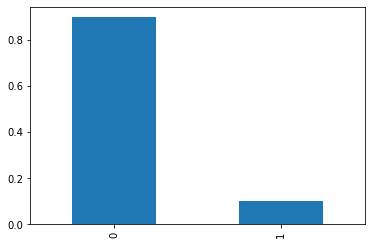

In [6]:
df['toxic'].value_counts(normalize=(0, 1)).plot(kind='bar')

**Вывод**

Мы наблюдаем дисбаланс классов в отношении примерно 1 к 9. 
<br>Далее учтём это и будем применять в моделях дисбаланс классов.

### Лематизация и очистка текстов

Переведём тип данных в столбце `text` с `object` на `list`

In [7]:
df['clear_text'] = list(df['text'])

Напишем функцию для лемматизации текстов

In [8]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

Напишем функцию для очистки текстов от лишних символов с помощью регулярных выражений

In [9]:
def clear_text(text):
    eng_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    
    return " ".join(eng_text.split())

Считаю, что будет целесообразно обрезать длину каждого комментария до 1000 символов, тк я провел несколько экспериментов с длиной  текстов 5000, 2000, 1000, 500, 300, 220, 200, 190, 180, 150  и 100 символов.
<br>Наилучшие результаты метрики F1-score получились на длине текстов в 1000 символов.

In [10]:
df['clear_text'] = df.clear_text.str.slice(start=0, stop=1000)

Лемматизируем тексты

In [11]:
%%time

df['clear_text'] = df.text.apply(lemmatize_text)

Wall time: 42.2 s


In [12]:
df['clear_text'] = df.clear_text.apply(" ".join)

Очистим текст от лишних символов

In [13]:
%%time

df['clear_text'] = df.clear_text.apply(lambda x: clear_text(x))

Wall time: 2.23 s


**Вывод**
<br><br> Тексты комментариев лемматизированя, очищены от лишних символов и обрезаны.

### Разобьём данные на выборки

Сделаем 2 выборки - обучающую и тестовую в пропорциях 80% к 20% соответственно.

In [14]:
train, test = train_test_split(df, test_size=0.2, random_state=12345)
print('Размер обучающей выборки -', train.shape, '\nРазмер тестовой выборки -', test.shape)

Размер обучающей выборки - (127433, 3) 
Размер тестовой выборки - (31859, 3)


Разделим учебную и тестовую выборки на признаки и цели

In [15]:
features_train = train.drop(['toxic'], axis=1)
target_train = train['toxic']
features_test = test.drop(['toxic'], axis=1)
target_test = test['toxic']

print('Размер features_train -', features_train.shape, 
      '\nРазмер target_train -', target_train.shape,
      '\nРазмер features_test -',features_test.shape, 
      '\nРазмер target_test -', target_test.shape)

Размер features_train - (127433, 2) 
Размер target_train - (127433,) 
Размер features_test - (31859, 2) 
Размер target_test - (31859,)


**Вывод**

Мы разделили датасет на две выборки:
* обучающую, чтобы обучить модели
* тестовую, чтобы правильно оценить готовую модель

### Мешок слов

Сделаем корпуса слов из очищенных стекстов столбца `clear_text` в признаках в обучающей и тестовой выборках

In [16]:
corpus = features_train['clear_text'].values
corpus_test = features_test['clear_text'].values

Удалим стоп-слова для английского языка

In [17]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Дмитрий\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Векторизируем тексты из обучающей и тестовой выборок

In [18]:
vectorizerCount = CountVectorizer(stop_words=stopwords)
x_train_count = vectorizerCount.fit_transform(corpus)
x_test_count = vectorizerCount.transform(corpus_test)

### TF-IDF

Вычислим TF-IDF тексты из обучающей и тестовой выборок

In [19]:
tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range = (1, 2))
x_train_tf_idf = tf_idf.fit_transform(corpus)
x_test_tf_idf = tf_idf.transform(corpus_test)

## Обучение

Напишем функцию для дальнейшей проверки разных моделей

In [20]:
result = []
def model_train_test(model_type, x_train, x_test):
    model = model_type
    model.fit(x_train, target_train) 
    predictions = model.predict(x_test)
    result.append(f1_score(target_test, predictions))
    return print(classification_report(target_test, predictions), '\n F1-score =',f1_score(target_test, predictions), '\n')        

### Логистическая регрессия

Посмотрим результаты модели на признаках с мешком слов

In [21]:
%%time 

model_train_test(LogisticRegression(solver="saga", n_jobs=-1, class_weight='balanced'), x_train_count, x_test_count)

              precision    recall  f1-score   support

           0       0.97      0.85      0.91     28629
           1       0.37      0.81      0.51      3230

    accuracy                           0.84     31859
   macro avg       0.67      0.83      0.71     31859
weighted avg       0.91      0.84      0.87     31859
 
 F1-score = 0.5088028169014085 

Wall time: 12.8 s


D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Посмотрим результаты модели на признаках с TF-IDF

In [22]:
%%time

model_train_test(LogisticRegression(solver="saga", n_jobs=-1, class_weight='balanced'), x_train_tf_idf, x_test_tf_idf)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     28629
           1       0.67      0.85      0.75      3230

    accuracy                           0.94     31859
   macro avg       0.83      0.90      0.86     31859
weighted avg       0.95      0.94      0.94     31859
 
 F1-score = 0.7470997679814384 

Wall time: 44.1 s


D:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


**Вывод**

Лучший показатель Логистической регрессии F1-score = 0.747

### Дерево решений

Напишем функцию для подбора лучшей глубины дерева

In [23]:
def tree(x_train, x_test):
    best_model_tree = None
    best_result = 0
    for i in range(1, 25, 3):
        model_tree = DecisionTreeClassifier(max_depth = i)
        model_tree.fit(x_train, target_train)
        predictions = model_tree.predict(x_test)
        result = f1_score(target_test, predictions)
        if result > best_result:
            best_result = result 
            best_model_tree = model_tree
    
    return print("F1-score =", best_result, "\nНаилучшая модель с параметрами:", best_model_tree)

Посмотрим на какой глубине дерева оптимально будет работать модель и будет выдавать наилучшее значение F1-score

In [24]:
%%time

tree(x_train_count, x_test_count)

F1-score = 0.6562974203338391 
Наилучшая модель с параметрами: DecisionTreeClassifier(max_depth=22)
Wall time: 26.7 s


In [25]:
%%time

tree(x_train_tf_idf, x_test_tf_idf)

F1-score = 0.6655192197360872 
Наилучшая модель с параметрами: DecisionTreeClassifier(max_depth=22)
Wall time: 5min 15s


**Вывод**

Лучший показатель Дерева решений F1-score = 0.665

### LightGBM

Посмотрим результаты модели на признаках с мешком слов

In [26]:
%%time

model_train_test(LGBMClassifier(), x_train_count.astype('float32'), x_test_count.astype('float32'))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28629
           1       0.89      0.63      0.74      3230

    accuracy                           0.95     31859
   macro avg       0.93      0.81      0.86     31859
weighted avg       0.95      0.95      0.95     31859
 
 F1-score = 0.7368612474995454 

Wall time: 10.7 s


Посмотрим результаты модели на признаках с TF-IDF

In [27]:
%%time

model_train_test(LGBMClassifier(), x_train_tf_idf.astype('float32'), x_test_tf_idf.astype('float32'))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28629
           1       0.88      0.66      0.76      3230

    accuracy                           0.96     31859
   macro avg       0.92      0.83      0.87     31859
weighted avg       0.95      0.96      0.95     31859
 
 F1-score = 0.7563173705601697 

Wall time: 1min 10s


**Вывод**

Лучший показатель LGBM F1-score = 0.756

### CatBoost

Посмотрим результаты модели на признаках с мешком слов

In [28]:
%%time

model_train_test(CatBoostClassifier(iterations=50, class_weights = (1, 9)), x_train_count, x_test_count)

Learning rate set to 0.5
0:	learn: 0.5652124	total: 873ms	remaining: 42.8s
1:	learn: 0.5258784	total: 1.62s	remaining: 38.9s
2:	learn: 0.4972502	total: 2.37s	remaining: 37.1s
3:	learn: 0.4753412	total: 3.1s	remaining: 35.7s
4:	learn: 0.4558637	total: 3.83s	remaining: 34.4s
5:	learn: 0.4428537	total: 4.54s	remaining: 33.3s
6:	learn: 0.4312961	total: 5.27s	remaining: 32.4s
7:	learn: 0.4234726	total: 6s	remaining: 31.5s
8:	learn: 0.4148625	total: 6.71s	remaining: 30.6s
9:	learn: 0.4074721	total: 7.46s	remaining: 29.9s
10:	learn: 0.4047467	total: 8.19s	remaining: 29s
11:	learn: 0.4000870	total: 8.9s	remaining: 28.2s
12:	learn: 0.3960790	total: 9.63s	remaining: 27.4s
13:	learn: 0.3916961	total: 10.3s	remaining: 26.6s
14:	learn: 0.3885243	total: 11s	remaining: 25.7s
15:	learn: 0.3856575	total: 11.8s	remaining: 25s
16:	learn: 0.3807267	total: 12.5s	remaining: 24.2s
17:	learn: 0.3784751	total: 13.2s	remaining: 23.5s
18:	learn: 0.3756470	total: 13.9s	remaining: 22.7s
19:	learn: 0.3720004	total:

**Вывод**

Лучший показатель  CatBoost F1-score = 0.727

## Выводы

Результаты исследования  отображены в таблице ниже

In [29]:
pd.DataFrame(result, 
             columns=['F1-score'], 
             index =['Логистическая регрессия с мешком слов', 'Логистическая регрессия с TF-IDF', 
                     'LightGBM с мешком слов', 'LightGBM с TF-IDF', 'CatBoost с мешком слов'])

,F1-score
Логистическая регрессия с мешком слов,0.508803
Логистическая регрессия с TF-IDF,0.747100
LightGBM с мешком слов,0.736861
LightGBM с TF-IDF,0.756317
CatBoost с мешком слов,0.726867


<br>Наилучшие результаты метрики F1-score получились на длине текстов в 1000 символов. 
<br>Я провел несколько экспериментов с длиной текстов 5000, 2000, 1000, 500, 300, 220, 200, 190, 180, 150 и 100 символов. 
<br>У нас наблюдается дисбаланс классов. 
<br>Модели  пробовал применять с балансом классов и без баланса.
<br>Лучший результат модели был достигнут в модели LightGBM с TF-IDF без баланса классов, значение `F1-score = 0.756317`.
<br>По ТЗ нужно было достигнуть значения `F1-score = 0.75`.
<br>Остальные модели не достигли нужного показателя, как с балансом классов, так и без баланса.